In [8]:
DES_TYPE_KAZE = 'kaze'
DES_TYPE_SIFT = 'sift'

import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import plotly.io as pio
pio.renderers.default = "notebook"

# uncomment if optuna is not yet installed
# !pip install optuna
import optuna

*Uncomment cell below if running from Google Colab*

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/proj1/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/18AvVUMAtFAWd7oJA-GIaUb9avEP8dQAS/proj1


Read the train and test files

In [ ]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['.' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['.' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb')) 
test_labels = pickle.load(open('test_labels.dat','rb'))

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

Codeblock for Descriptors

In [ ]:
def get_descriptors(trial, X_train):
    Train_descriptors = []

    des_type = trial.suggest_categorical("des_type", [DES_TYPE_KAZE, DES_TYPE_SIFT])
    if des_type == DES_TYPE_KAZE:
        Detector = cv2.KAZE_create(threshold=0.0001)
        percentage = trial.suggest_int('percentage', 10, 100, step=10)
    elif des_type == DES_TYPE_SIFT:
        Detector = cv2.SIFT_create()
        kpt_step = trial.suggest_categorical('kpt_step', [4, 8, 16, 32])


    for filename in tqdm(X_train, "Computing descriptors", leave=False):
        #fix filename (remove ../ prefix)
        #filename = Path(filename)
        #filename = str(Path(*filename.parts[1:]))

        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
        if des_type == DES_TYPE_KAZE:
            kpt, des = Detector.detectAndCompute(gray, None)
            count = int(len(des) * percentage / 100)
            np.random.seed(0)
            np.random.shuffle(des)
            des = des[0:count]
        elif des_type == DES_TYPE_SIFT:
            kpt = [cv2.KeyPoint(x, y, kpt_step) for y in range(0, gray.shape[0], kpt_step) 
                                    for x in range(0, gray.shape[1], kpt_step)]
            kpt, des = Detector.compute(gray, kpt)
        Train_descriptors.append(des)
    
    return Train_descriptors

Codeblock for KMeans

In [ ]:
def compute_bags(trial, Train_descriptors, Test_descriptors):
    """
    Train\Test_descriptors is a LIST of arrays, where each array represents an image
    its shape is (n_detected_keypoints, n_features)
    
    Return array of shape (n_images, codebook_size)"""
    
    # get_codebook
    k = trial.suggest_categorical("k", [16, 32, 64, 128, 256, 512])
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(np.vstack(Train_descriptors))
    
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i]) # array of labels (quantized/clustered descriptors), they are ints [0;k)
        visual_words[i,:]=np.bincount(words,minlength=k)

    visual_words_test=np.zeros((len(Test_descriptors),k),dtype=np.float32)
    for i in range(len(Test_descriptors)):
        words=codebook.predict(Test_descriptors[i]) # array of labels (quantized/clustered descriptors), they are ints [0;k)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    
  
    return visual_words, visual_words_test

Codeblock for Dimensionality Reduction


In [ ]:
def dimensionality_reduction(trial, X_train, y_train, X_validate):
    dimensionality_reduction = trial.suggest_categorical("DR_technique", ['PCA', 'LDA'])
    number_of_components = trial.suggest_categorical("n_components", range(2,8))

    if dimensionality_reduction == 'PCA':
        pca = PCA(n_components=number_of_components)
        X_train_DR = pca.fit_transform(X_train)
        X_validate_DR = pca.transform(X_validate)
    elif dimensionality_reduction == 'LDA':
        lda = LinearDiscriminantAnalysis(n_components=number_of_components)
        X_train_DR = lda.fit_transform(X_train, y_train)
        X_validate_DR = lda.transform(X_validate)

    return X_train_DR, X_validate_DR

Codeblock for KNN

In [ ]:
def fit_transform_knn(trial, X_train, Y_train, X_test):
        n_neighbours = trial.suggest_int("n_neighbours", 1, 32)
        knn_metric = trial.suggest_categorical("knn_metric", ["cosine", "euclidean", "manhattan"])
        knn = KNeighborsClassifier(n_neighbors=n_neighbours,n_jobs=-1,metric=knn_metric)
        knn.fit(X_train, Y_train)
        Y_test = knn.predict(X_test)
        
        return Y_test

## Codeblock for main function and cross-validation

Test dataset can't be used for h-param optimization, as it will lead to data leakage, i.e. the model's performance will be influenced by the data outside the Training set. Therefore we use k-fold cross validation splitting of Training set to estimate accuracy during h-param optimization. And we use the Test set only in the end, when we test the best final model.

In [ ]:
kf = KFold(n_splits=5, shuffle=True)
folds = list(kf.split(train_images_filenames))

In [ ]:
def objective(trial):
    """Average accuracy estimations across cross-validation folds"""

    cumulative_accuracy = 0
    Descriptors = get_descriptors(trial, train_images_filenames)
    Descriptors = np.array(Descriptors)  # to be able to access via multi-index
    is_first_fold = True
    for fold in tqdm(folds, "Fold", leave=False):
        X_train, y_train = Descriptors[fold[0]], train_labels[fold[0]]
        X_validate, y_validate = Descriptors[fold[1]], train_labels[fold[1]]
        visual_words_train, visual_words_validate = compute_bags(trial, X_train, X_validate) # Kyryls's code which takes lists of Train and Test arrays-of-descriptors and returns their visual words representation
        X_train_DR, X_validate_DR = dimensionality_reduction(trial, visual_words_train, y_train, visual_words_validate)
        pred_validate = fit_transform_knn(trial, X_train_DR, y_train, X_validate_DR) # Kyryl's code which takes X_validate_DR returns the pred_validate_DR
        val_score = accuracy_score(y_validate, pred_validate)
        cumulative_accuracy += val_score

        # fix trial for following folds. All params must be same accross folds
        if is_first_fold:
            is_first_fold = False
            trial = optuna.trial.FixedTrial(trial.params)

    accuracy = cumulative_accuracy / kf.n_splits

    return accuracy

In [4]:
study = optuna.create_study(direction="maximize", study_name='complete-study', storage='sqlite:///final60.db', load_if_exists=True)
# study.optimize(objective, n_trials=50)  # already done

[I 2023-01-08 22:08:53,645] Using an existing study with name 'complete-study' instead of creating a new one.


# The results

The impact of individual parameters on the objective function can be estimated with slice plots. The explanation is written below the plots. 

In [9]:
optuna.visualization.plot_slice(study, params=["des_type","kpt_step","percentage"])

The screenshot below is included since the plot above is not shown in some notebook editors

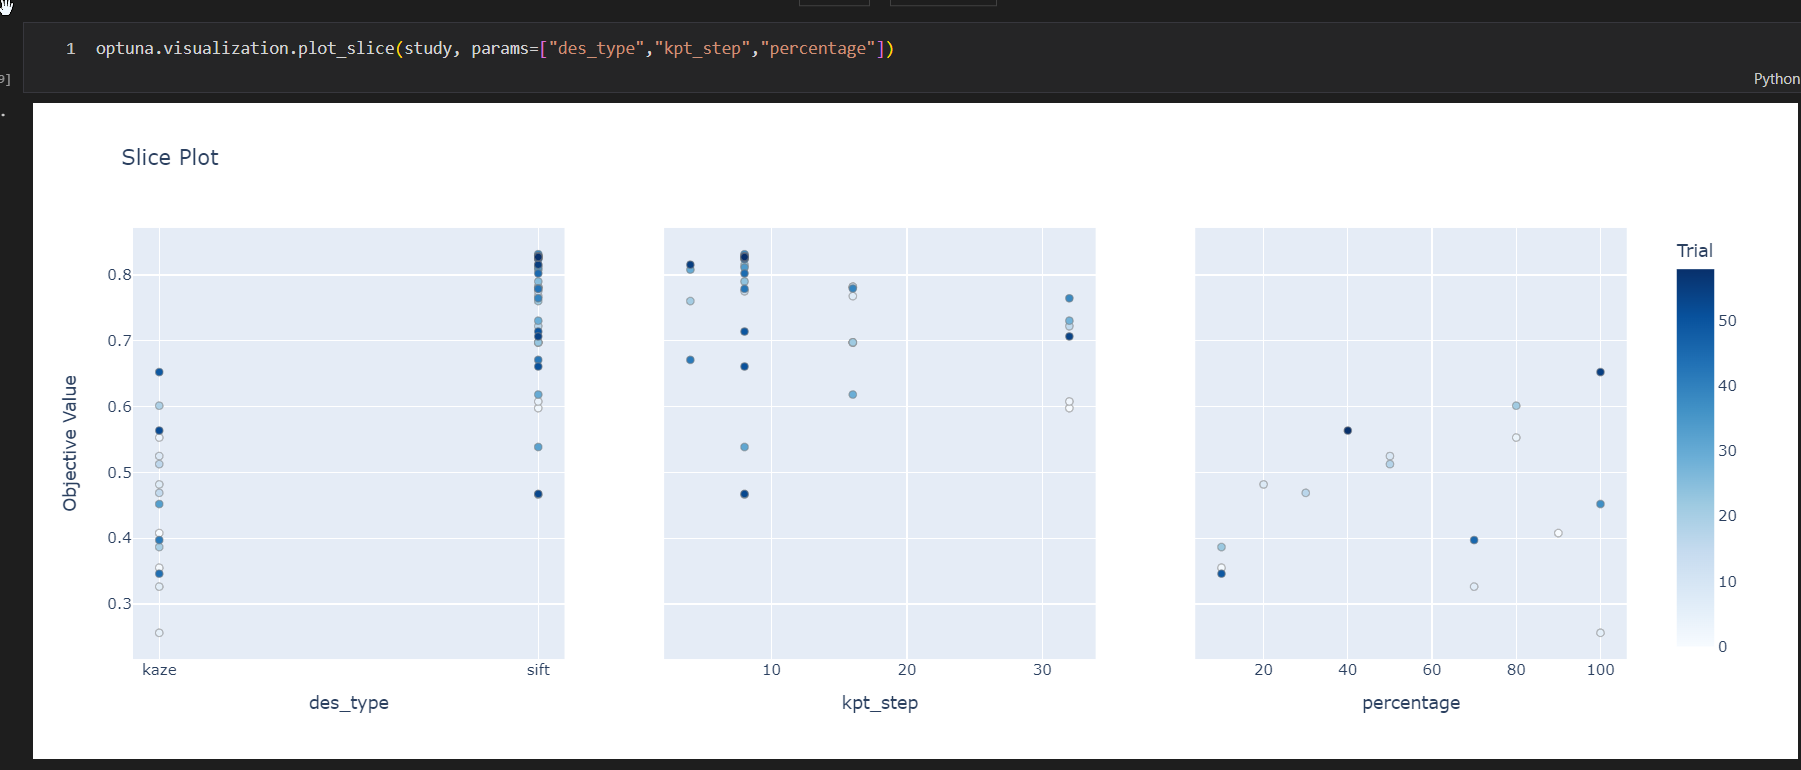

**TASK #1: find the relation between the number of local features and accuracy**

Since the provided notebook uses KAZE, this test was only conducted on KAZE.
To change the number of local features, a subset of x% random descriptors is selected.*

Looking at the plots above, specifically the one about **percentage**: x=100 gave the best result (0.65), but x=70 is a close second with a difference of ~0.05 in accuracy.
In case this difference in accuracy is negligible to the use case, 70% of descriptors might be 
a better candidate to larger training sets to improve the execution time.
**In conclusion, the best results are obtained when we use more descriptors.**


---


**TASK #2: compare the results of detected keypoints (KAZE)and dense SIFT**


Dense SIFT has been removed from the OpenCV library, hence we have implemented a simple version of it divinding images (original scale) into keypoints with centers at each **kpt_step** pixels.

Looking at the plots above, specifically the one about **kpt_step**: x=8 gave the best result (0.83). 
Smaller blobs result in more descriptors. But for excessively small blobs (with centers at every 4 pixels for our training set) accuracy starts to decrease.
The best results might be chosen by a ratio based on the size of the image and the size of the keypoints.

Now comparing the two: dense SIFT and KAZE, looking at the first plot above, it can be seen that dense SIFT has better results than KAZE with quite a big difference in accuracy (0.83 vs 0.65 best accuracy for both).


.* Tests have been conducted to influence the number of keypoints for KAZE, but they have failed when using the OpenCV library.

In [10]:
optuna.visualization.plot_slice(study, params=["k", "n_neighbours", "knn_metric"])

The screenshot below is included since the plot above is not shown in some notebook editors

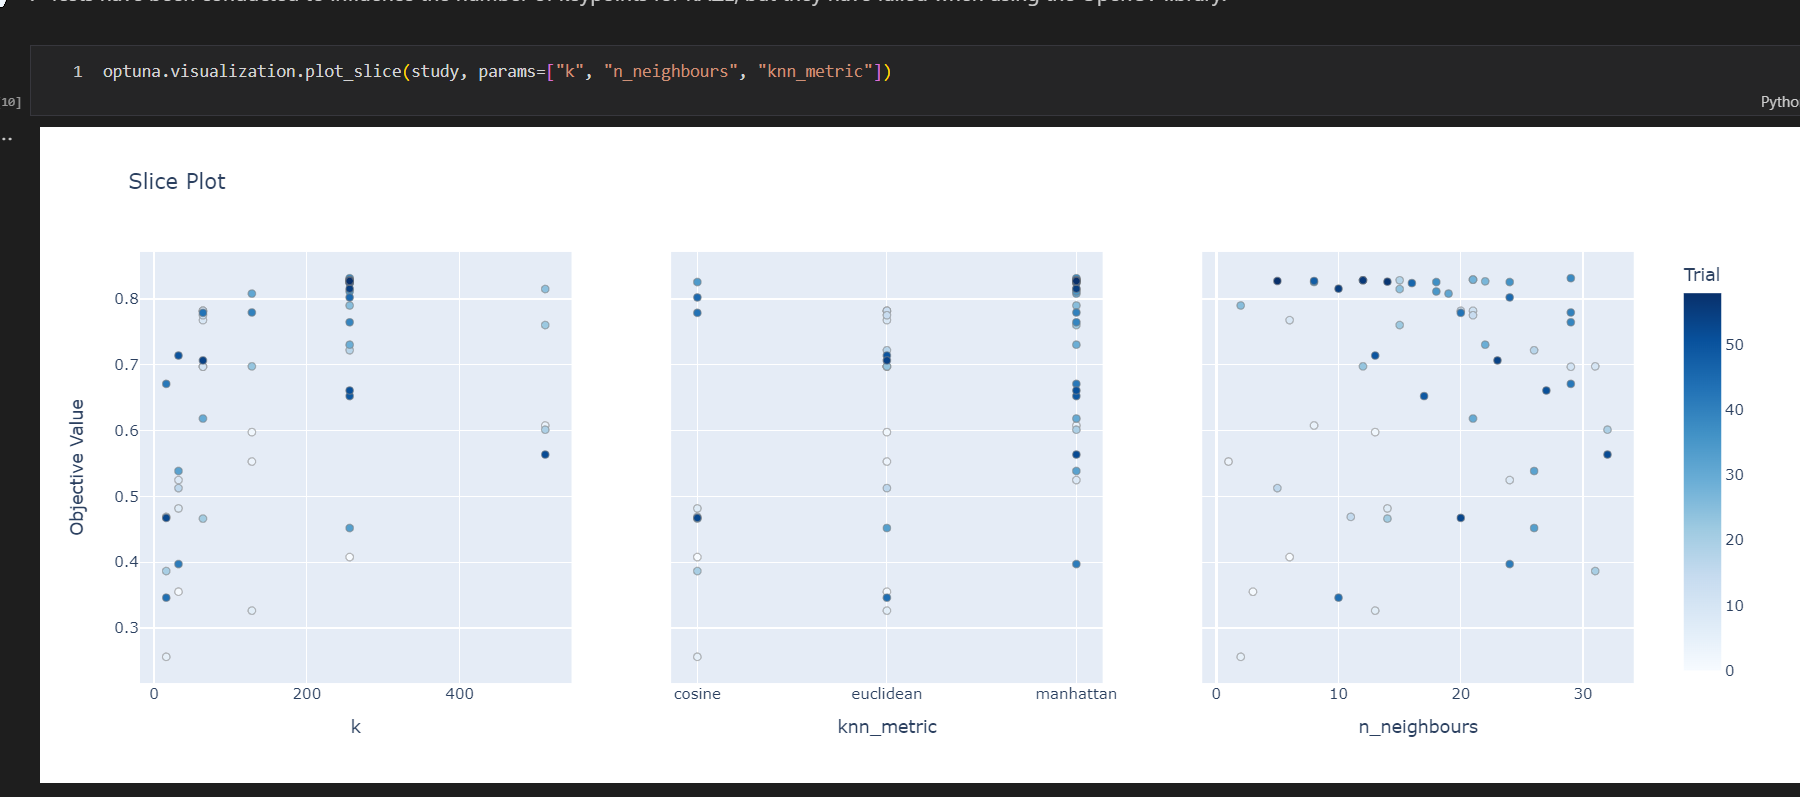

**TASK #3: test different codebooks sizes**

Codebook (AKA dictionary) size is completely defined by the number of clusters (words) in which we quantize the descriptor's feature space. The smaller it is -- the more general our words' become. On the other side, if k is a big number, words become too specific, their meanings become closer to the values of individual descriptors, which leads to overfitting.

On the chart above we can see that at the beginning the accuracy goes up when we increase k. Then it reaches its maximum at k=256 and goes slightly down on k=512. It can be caused by the overfitting. We have not include higher values of k in this testing, because the BoVW algorithm becomes unreasonable computationaly expensive in such case, but we tried optimizing k also with values of 1024 and 2048 in an isolated experiment (out of this notebook). 1024 and 2048 -values were even worse than 512, which proves the fact that there is a happy medium of k-value, lower than which we have the underfitting, and overfitting if higher.

---

**TASK #4: test different k in knn classifier**
During knn classification, k defines the number of the closest neighbors which take a part in the voting process.

As you can see on the chart above, the trials with the highest accuracy metric, have almost evenly distributed values of the nearest neighbors parameter. It means that this parameter doesn't matter so much.

Probably it is the case, because the BoVW represenation of our train dataset form mostly non-overlapping classes, which allows us to robustly perform classification with the smallest numbers of voters (nearest neighbors)

---

**TASK #5: test different metrics for knn**
It is a tricky parameter to inerpret. BoVW vectors are all in the first quadrant of the k-dimensional parameter space, because they all are histograms in their nature. Therefore the difference between differenct distance metrics shouldn't be very prominent: in this case, cosine can't output negative values, for example.

Also it is almost impossible to properly estimate the impact of the knn metric on the final accuracy, due to the reasons, mentioned in **TASK 4**: easily separable, non-overlapping classes of training set in BoVW representation.

Though, Optuna decided to converge with the Manhattan distance.

In [11]:
optuna.visualization.plot_slice(study, params=["DR_technique","n_components"])

The screenshot below is included since the plot above is not shown in some notebook editors

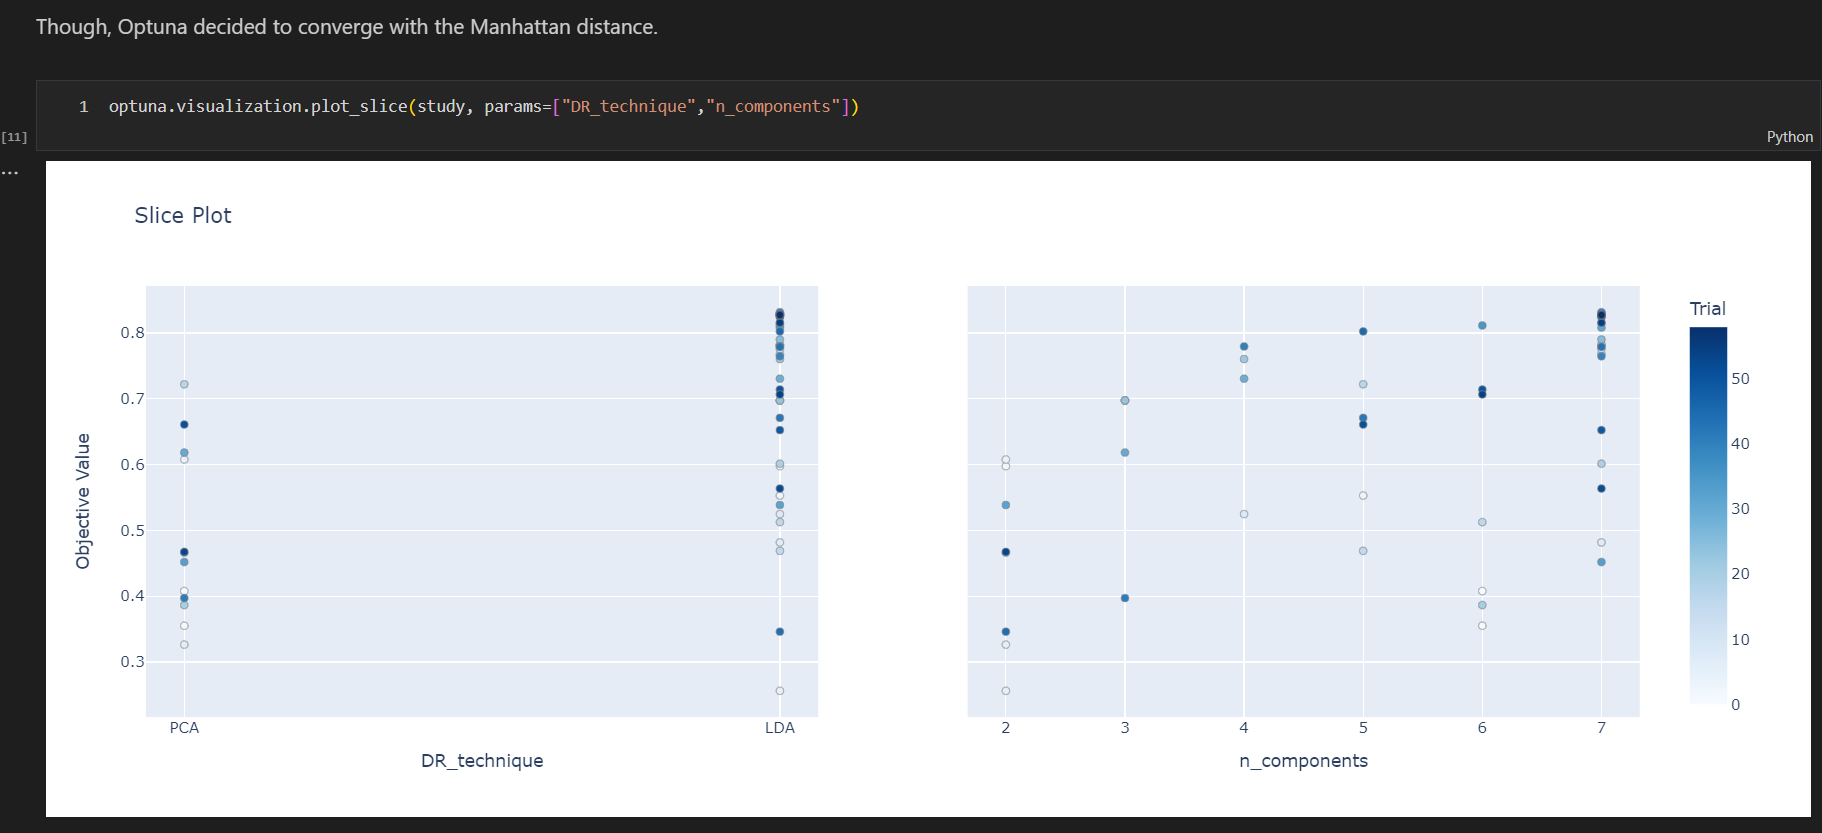

**TASK #6: Play with reducing dimensionality. Conclusions?**

We tested two dimensionality reduction techniques: PCA and LDA. For both techniques we investigated the effect of varying the number of components on the accuracy. 

The first plot above shows the accuracy on the y-axis and the dimensionality reduction technique on the x-axis. The color corresponds to the trial number of the result. We see that we generally get higher accuracies when using LDA over PCA. The highest accuracy achieved using PCA was 0.72 while the highest accruacy using LDA was 0.83.

The second plot has the same structure as the first plot, where we now have the number of components on the x-axis. We tested all possible number of components, since 7 is the minimum of the number of samples and variables minus 1. We see that the accuracy generally increases as the number of components. We get the best accuracy with 7 components, being 0.83.	

# Overal results parameter tuning

**Parallel coordinates plot** is a very insightful plot which allows us to see, for example, what parameters are usually associated with certain Objective function metric.

It is possible to plot such chart only if every trial in the study object utilizes ALL parameters. Which isn't our case, because due to descriptor type branching, we can not simultaneously estimate kpt_step and percentage.

But we know that according to study.best_params, SIFT is preferred as a descriptor. So if we anyway will stick to SIFT, we can "fix" this decision, and, therefore, eliminate branching. Which allows us to plot Parallel coordinates 

In [14]:
sift_trials = [trial for trial in study.trials if trial.params["des_type"] == "sift"]
sift_study = optuna.create_study()

for trial in sift_trials:
    sift_study.add_trial(trial)
    
fig = optuna.visualization.plot_parallel_coordinate(sift_study, target=lambda t: t.values[0])
fig.data[0].line.reversescale = not fig.data[0].line.reversescale
fig.show()

[I 2023-01-08 22:16:13,323] A new study created in memory with name: no-name-d00c3c6e-852e-41d8-90b6-a510fc2f6b9a


The screenshot below is included since the plot above is not shown in some notebook editors

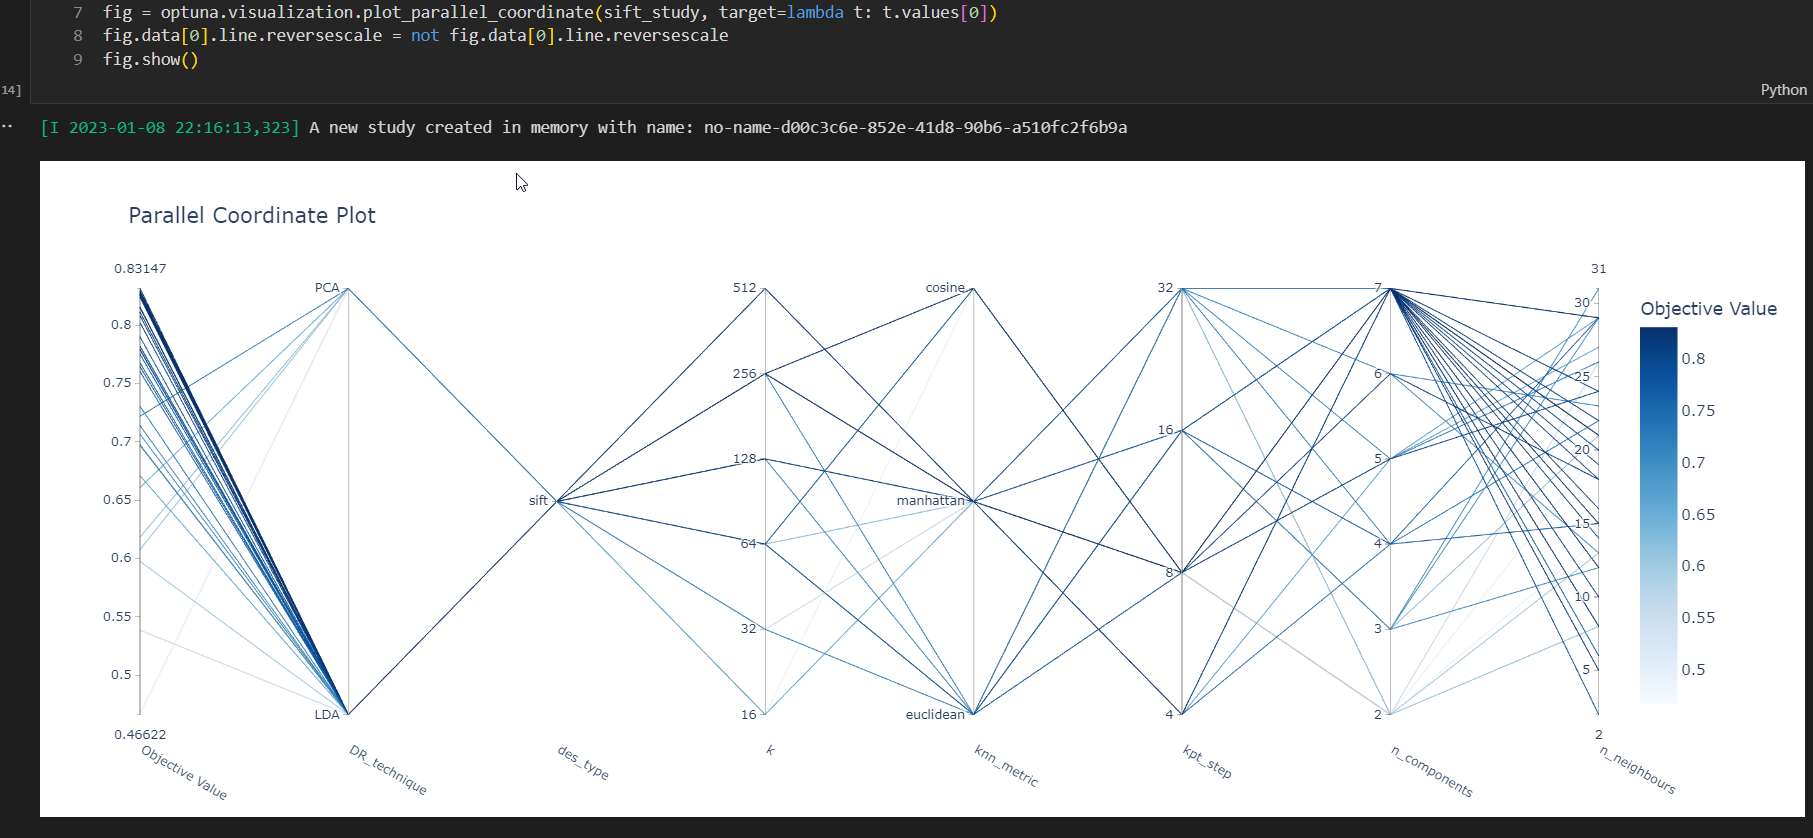

From the Parallel coordinates plot above, we can extract insights on preferred parameters combinations. For example, if we highlight trials associated with the highest accuracy, we can see that those trials correspond to cobinations of LDA with 7 components, almost unconditionally to other params.

In [13]:
kaze_trials = [trial for trial in study.trials if trial.params["des_type"] == "kaze"]
kaze_study = optuna.create_study()

for trial in kaze_trials:
    kaze_study.add_trial(trial)
    
fig = optuna.visualization.plot_parallel_coordinate(kaze_study, target=lambda t: t.values[0])
fig.data[0].line.reversescale = not fig.data[0].line.reversescale
fig.show()

[I 2023-01-08 22:16:09,923] A new study created in memory with name: no-name-271a6e74-960d-4e71-a91a-0a701868f52a


The screenshot below is included since the plot above is not shown in some notebook editors

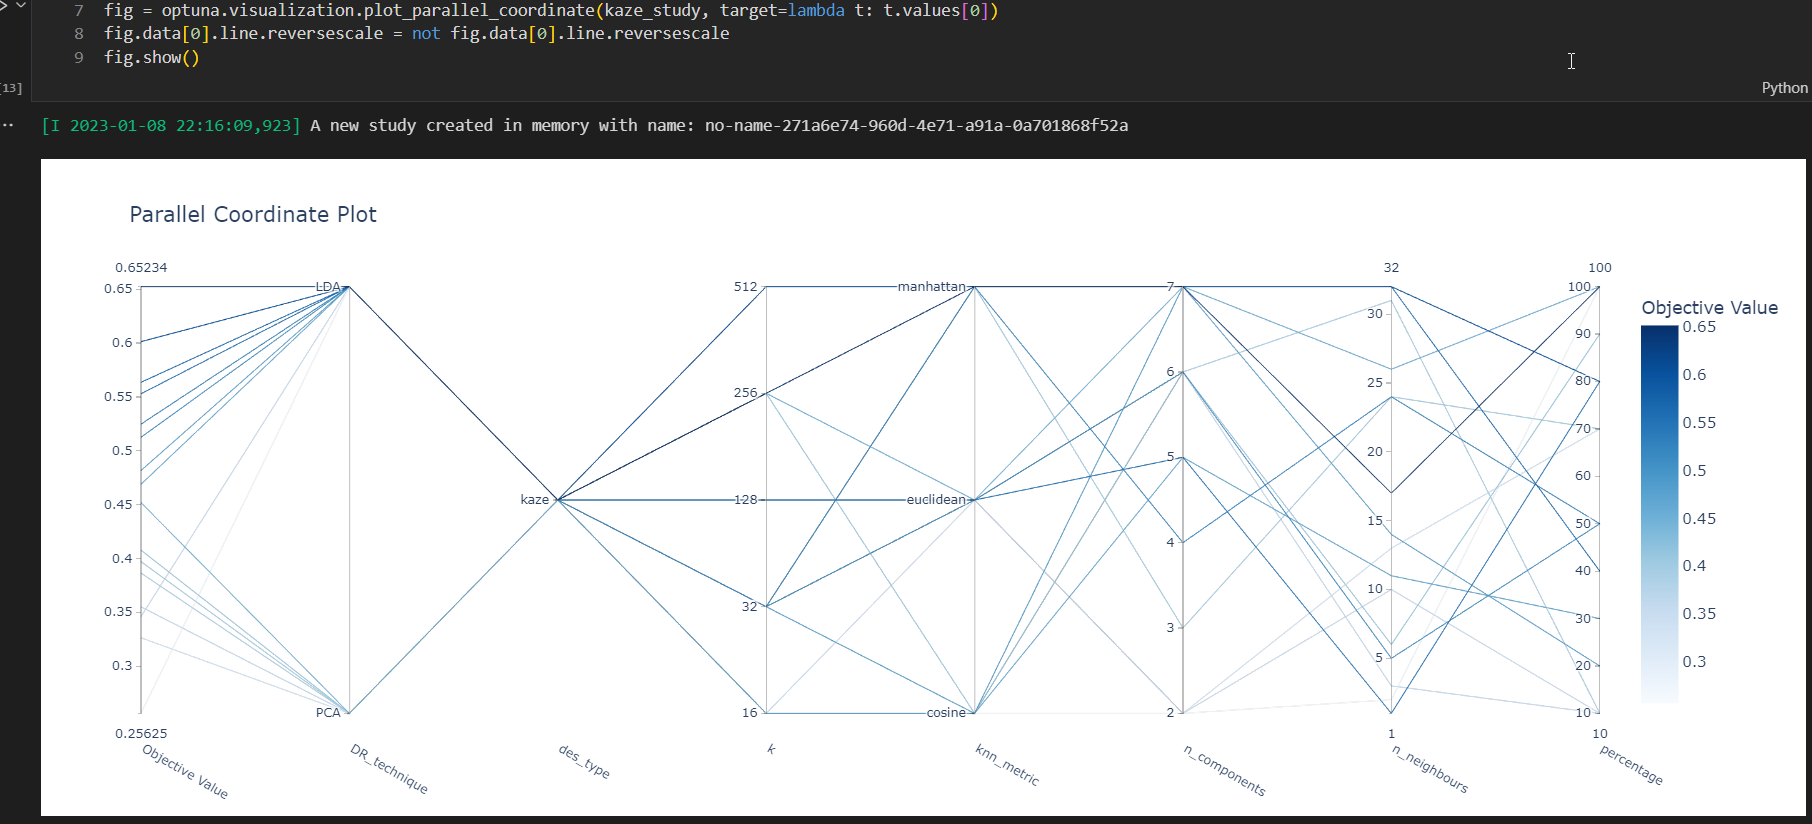

Optuna also provides metrics to directly estimate importances of parameters

In [15]:
optuna.visualization.plot_param_importances(study)

The screenshot below is included since the plot above is not shown in some notebook editors

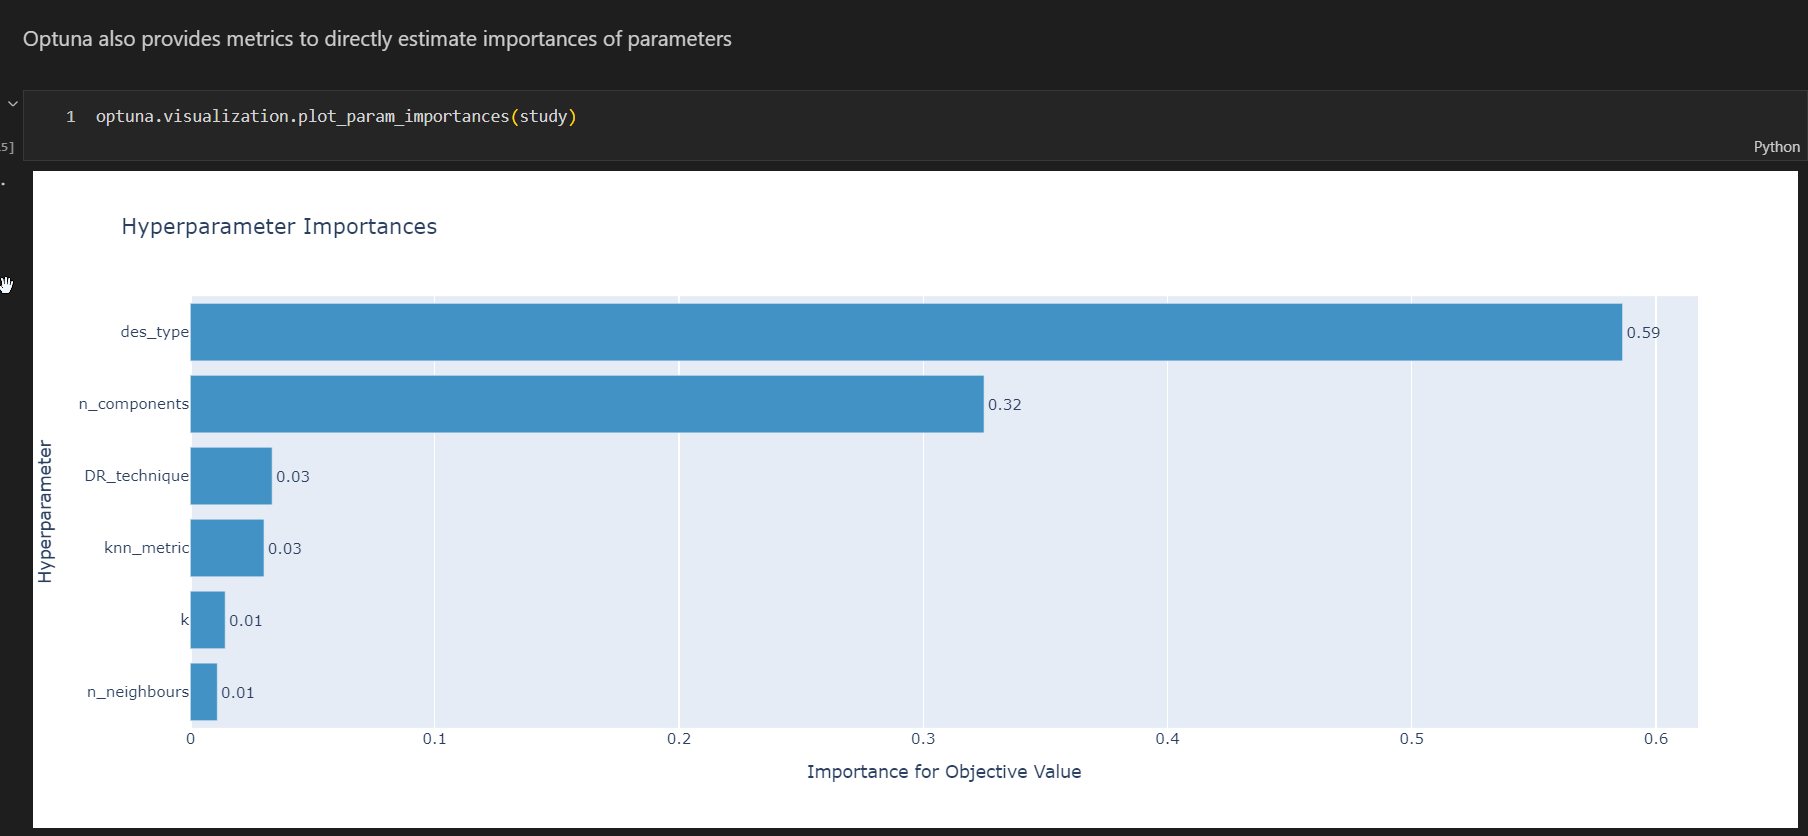

# Training a final model with the best set of parameters. Testing it on the test set (unseen before)

In [ ]:
study.best_params

{'DR_technique': 'LDA',
 'des_type': 'sift',
 'k': 256,
 'knn_metric': 'manhattan',
 'kpt_step': 8,
 'n_components': 7,
 'n_neighbours': 29}

In [ ]:
trial = study.best_trial

X_train = get_descriptors(trial, train_images_filenames)
y_train = train_labels
X_test = get_descriptors(trial, test_images_filenames)
y_test = test_labels


visual_words_train, visual_words_validate = compute_bags(trial, X_train, X_test) 
X_train_DR, X_validate_DR = dimensionality_reduction(trial, visual_words_train, y_train, visual_words_validate)
pred_validate = fit_transform_knn(trial, X_train_DR, y_train, X_validate_DR)

Computing descriptors:   0%|          | 0/1881 [00:00<?, ?it/s]

Computing descriptors:   0%|          | 0/807 [00:03<?, ?it/s]

In [ ]:
val_score = accuracy_score(y_test, pred_validate)
print(f"Accuracy for the best set of params is {val_score}")

Accuracy for the best set of params is 0.8438661710037175


# Other experiments

In this part we present code snippets we experimented with but were not used in the final method.

**Tiling**: BoVW representation doesn't preserve spatial relations of words in histogram. But if we split an image into tiles, and calcualte an individual histogram for each of them (and concatenate these histograms then), the resulting "long" histogram will contain some rough spatial relations between words.

We implemented tiling, but it hadn't any impact on accuracy.

The code is following:


```
def split_in_tiles(img, order=1):
    """Input shape is H, W, C;
    Retrurn list, where each element is a tile of a spatial piramid
    """
    
    n_sections = 2 ** order
    stripes = np.split(img, n_sections)
    tiles = [np.split(stripe, n_sections, 1) for stripe in stripes]
    tiles = sum(tiles, []) 
    return tiles

# ........ inside histogram calculation:
tiles = split_in_tiles(gray, 1)
spatial_histograms = []
for tile in tiles:
    kpt,des=Detector.detectAndCompute(gray,None)
    words=codebook.predict(des)
    spatial_histograms.append(np.bincount(words,minlength=k))
spatial_histograms = np.hstack(spatial_histograms)
```
It is suprising for us that tiling didn't improve accuracy.


**TF-IDF**: another concept which came from text mining field. It can also be applied for BoVW. Its idea is to normalize histograms, so they add up to 1 (they become probability distributions then). And also to scale each bin in histogram with respect to the "importance" or "uniqueness" of the word among all samples. Hence, distances between histograms become more meaningful. Somewhy this approach also haven't imporoved the accuracy. Here is our code for TF-IDF:


```
def get_idf(words):
    # TODO: fix iterative algos in main proj
    """Words is a matrix of shape (n_images, k (bins))"""
    N = len(words)
    df = np.sum(words.astype(np.bool8), axis=0)
    idf = np.log(np.divide(N, df))
    return idf

def apply_tf_idf(hists, idf):
    """hists is a matrix of shape (n_images, k (bins))"""
    # tf transform (make hist add up to 1)
    hists = np.divide(hists, np.sum(hists, axis=1).reshape((-1, 1)))  # reshape for broadcastability
    # idf transform
    hists = np.multiply(hists, idf)
    return hists
```


